In [271]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier,VotingClassifier,StackingClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score,roc_curve,auc

import warnings
warnings.filterwarnings("ignore")

In [302]:
!pip install catboost

In [304]:
from xgboost import XGBClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier

In [7]:
#load the dataset
train = pd.read_csv(r"C:\Users\infan\OneDrive\Desktop\Gayathri\dataset\hackathon-2[cross sell prediction]\train.csv")
test = pd.read_csv(r"C:\Users\infan\OneDrive\Desktop\Gayathri\dataset\hackathon-2[cross sell prediction]\test.csv")
submission = pd.read_csv(r"C:\Users\infan\OneDrive\Desktop\Gayathri\dataset\hackathon-2[cross sell prediction]\sample_submission.csv")

In [11]:
# classify numerical and categorical columns
num_col =[]
cat_col = []
target_col = ['Response']
ignore_col = ['id']
for col in train.columns:
    if col not in (target_col+ignore_col):
        if train[col].dtypes == 'object':
            cat_col.append(col)
        else:
            num_col.append(col)

In [19]:
cat_col_encode = Pipeline(steps=[
    ("one_hot_encoding",OneHotEncoder(handle_unknown='ignore'))
])
num_col_encode = Pipeline(steps=[
    ("standard_scalar",StandardScaler())
])
preprocess=ColumnTransformer(
    transformers=[
        ('cat_encode',cat_col_encode,cat_col),
        ('num_encode',num_col_encode,num_col)
    ]
)

In [23]:
X = train[num_col+cat_col]
y = train[target_col]

In [31]:
train_X, val_X, train_y, val_y = train_test_split(X,y,random_state=42, test_size=0.3)
train_X.shape , val_X.shape , train_y.shape,val_y.shape

((266776, 10), (114333, 10), (266776, 1), (114333, 1))

In [55]:
#model pipeline with preprocess and KNN model
model_pipeline=Pipeline(
    steps=[
        ('preprocess',preprocess),
        ('model',KNeighborsClassifier())
    ]
)

In [33]:
model_pipeline.fit(train_X, train_y)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat_encode',
                                                  Pipeline(steps=[('one_hot_encoding',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'Vehicle_Age',
                                                   'Vehicle_Damage']),
                                                 ('num_encode',
                                                  Pipeline(steps=[('standard_scalar',
                                                                   StandardScaler())]),
                                                  ['Age', 'Driving_License',
                                                   'Region_Code',
                                                   'Previously_Insured',
                                                   'Annual_Premium',
                                                   'Policy_Sales_Channel',
                                                   'Vintage'])])),
                ('model', KNeighborsClassifier())])

In [68]:
def model_train_val_eval(train_X,val_X,train_y,val_y,model_pipeline):
    
    predicted_train_tgt=model_pipeline.predict(train_X)
    predicted_val_tgt=model_pipeline.predict(val_X)

    predicted_praba_train_tgt = model_pipeline.predict_proba(train_X)[:,1]
    predicted_praba_val_tgt = model_pipeline.predict_proba(val_X)[:,1]
    
    print("train auc",roc_auc_score(train_y,predicted_praba_train_tgt),sep='\n')
    print("test auc",roc_auc_score(val_y,predicted_praba_val_tgt),sep='\n')
    
    print("train confusion matrix",confusion_matrix(train_y,predicted_train_tgt),sep='\n')
    print("test confustion matrix",confusion_matrix(val_y,predicted_val_tgt),sep='\n')
    
    print("train class matrix",classification_report(train_y,predicted_train_tgt),sep='\n')
    print("test class matrix",classification_report(val_y,predicted_val_tgt),sep='\n')
    
    y_pred_proba=model_pipeline.predict_proba(val_X)[:,1]
    plt.figure()
    fpr, tpr, thrshv= roc_curve(val_y,y_pred_proba)
#     roc_auc=auc(fpr,tpr)
    plt.plot(fpr,tpr)
    plt.show()

train auc
0.6577207633550792
test auc
0.5632220268510074
train confusion matrix
[[228276   5928]
 [ 21473  11099]]
test confustion matrix
[[95331  4864]
 [11664  2474]]
train class matrix
              precision    recall  f1-score   support

           0       0.91      0.97      0.94    234204
           1       0.65      0.34      0.45     32572

    accuracy                           0.90    266776
   macro avg       0.78      0.66      0.70    266776
weighted avg       0.88      0.90      0.88    266776

test class matrix
              precision    recall  f1-score   support

           0       0.89      0.95      0.92    100195
           1       0.34      0.17      0.23     14138

    accuracy                           0.86    114333
   macro avg       0.61      0.56      0.58    114333
weighted avg       0.82      0.86      0.83    114333



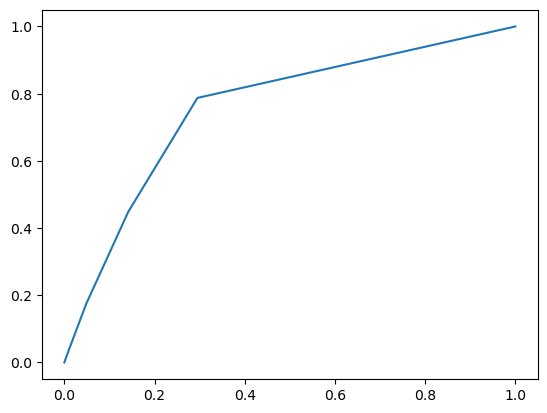

In [45]:
model_train_val_eval(train_X, val_X, train_y, val_y,model_pipeline)

In [53]:
submission['Response']=model_pipeline.predict(test)
submission.to_csv(r'C:\Users\infan\Documents\gayathri\cross_sell_prediction\csv files\knn.csv',index=False)

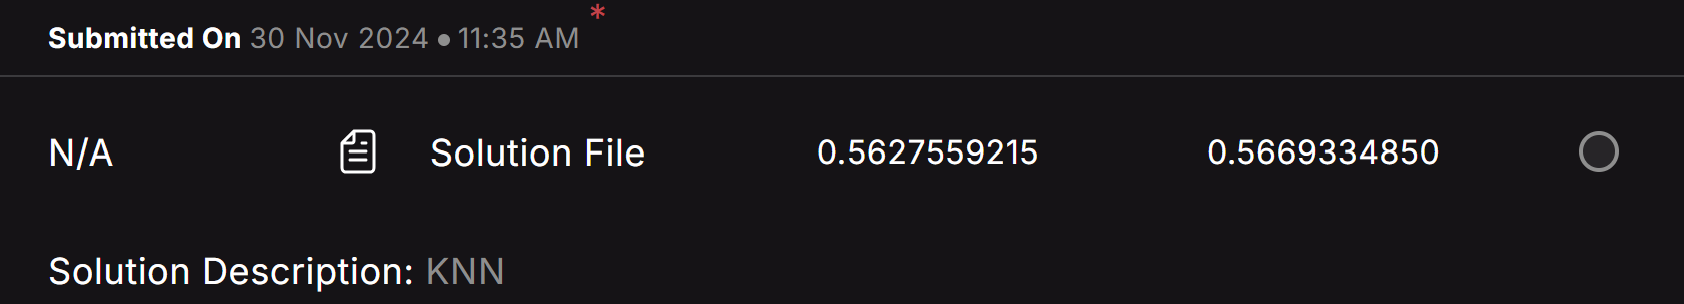

In [60]:
#model pipeline with preprocess and KNN model with gridsearch
model_pipeline1=Pipeline(
    steps=[
        ('preprocess',preprocess),
        ('model',KNeighborsClassifier())
    ]
)

params = {
    "model__n_neighbors":[5,3,7],
    "model__weights":['uniform', 'distance'],
    "model__algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'],
    "model__n_jobs": [-1]    
}

grid_search = GridSearchCV(estimator=model_pipeline1,param_grid=params,cv=5,scoring='roc_auc')
grid_search.fit(train_X,train_y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('cat_encode',
                                                                         Pipeline(steps=[('one_hot_encoding',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Gender',
                                                                          'Vehicle_Age',
                                                                          'Vehicle_Damage']),
                                                                        ('num_encode',
                                                                         Pipeline(steps=[('standard_scalar',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Driving_License',
                                                                          'Region_Code',
                                                                          'Previously_Insured',
                                                                          'Annual_Premium',
                                                                          'Policy_Sales_Channel',
                                                                          'Vintage'])])),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__algorithm': ['auto', 'ball_tree', 'kd_tree',
                                              'brute'],
                         'model__n_jobs': [-1], 'model__n_neighbors': [5, 3, 7],
                         'model__weights': ['uniform', 'distance']},
             scoring='roc_auc')

In [70]:
model1 = grid_search.best_estimator_


In [76]:
submission['Response']=model1.predict(test)
submission.to_csv(r'C:\Users\infan\Documents\gayathri\cross_sell_prediction\csv files\knn_gridsearch.csv',index=False)

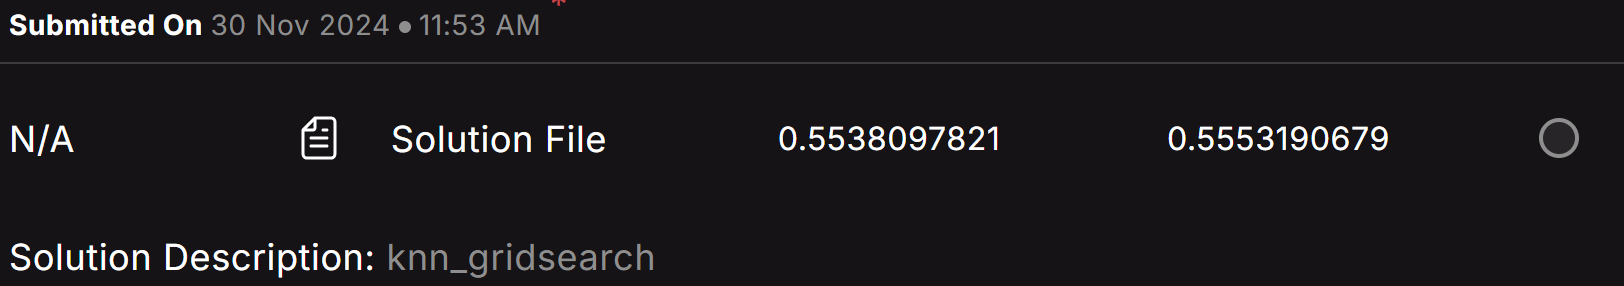

In [84]:
# undersampling
under_sampling=RandomUnderSampler()
train_X_under_sampled,train_y_under_sampled=under_sampling.fit_resample(train_X,train_y)
under_balanced_data=pd.concat([train_X_under_sampled,train_y_under_sampled] , axis =1)
print(under_balanced_data['Response'].value_counts())
under_balanced_data.head(2)

Response
0    32572
1    32572
Name: count, dtype: int64


,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Gender,Vehicle_Age,Vehicle_Damage,Response
238082,70,1,28.0,1,39158.0,122.0,20,Male,1-2 Year,No,0
55596,27,1,50.0,1,36609.0,152.0,209,Female,< 1 Year,No,0


train auc
0.854573901113504
test auc
0.8247890450091413
train confusion matrix
[[160993  73211]
 [  3000  29572]]
test confustion matrix
[[68395 31800]
 [ 1941 12197]]
train class matrix
              precision    recall  f1-score   support

           0       0.98      0.69      0.81    234204
           1       0.29      0.91      0.44     32572

    accuracy                           0.71    266776
   macro avg       0.63      0.80      0.62    266776
weighted avg       0.90      0.71      0.76    266776

test class matrix
              precision    recall  f1-score   support

           0       0.97      0.68      0.80    100195
           1       0.28      0.86      0.42     14138

    accuracy                           0.70    114333
   macro avg       0.62      0.77      0.61    114333
weighted avg       0.89      0.70      0.75    114333



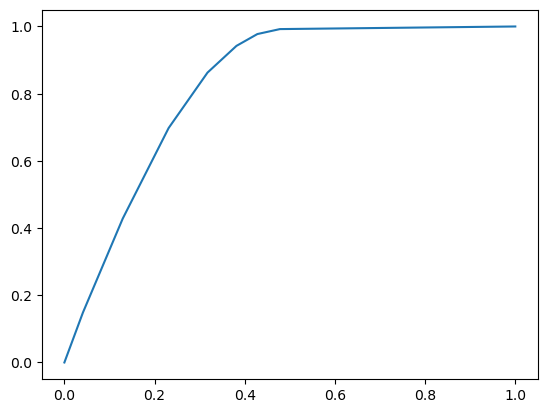

In [87]:
grid_search.fit(train_X_under_sampled,train_y_under_sampled)
model1_1 = grid_search.best_estimator_
model_train_val_eval(train_X, val_X, train_y, val_y,model1_1)

In [89]:
submission['Response']=model1_1.predict(test)
submission.to_csv(r'C:\Users\infan\Documents\gayathri\cross_sell_prediction\csv files\knn_gridsearch_undersampling.csv',index=False)

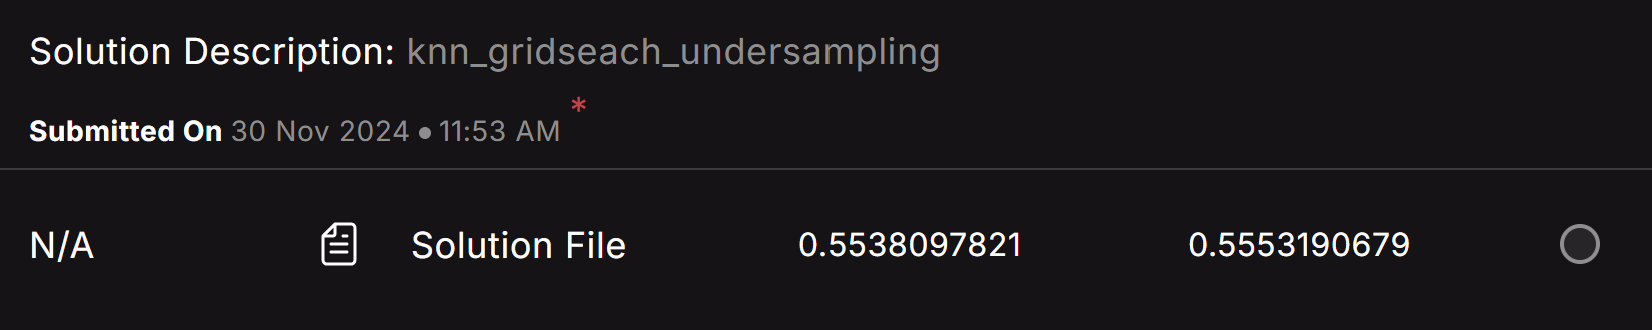

train auc
0.880046129369771
test auc
0.7168690352864114
train confusion matrix
[[178027  56177]
 [     6  32566]]
test confustion matrix
[[72455 27740]
 [ 4092 10046]]
train class matrix
              precision    recall  f1-score   support

           0       1.00      0.76      0.86    234204
           1       0.37      1.00      0.54     32572

    accuracy                           0.79    266776
   macro avg       0.68      0.88      0.70    266776
weighted avg       0.92      0.79      0.82    266776

test class matrix
              precision    recall  f1-score   support

           0       0.95      0.72      0.82    100195
           1       0.27      0.71      0.39     14138

    accuracy                           0.72    114333
   macro avg       0.61      0.72      0.60    114333
weighted avg       0.86      0.72      0.77    114333



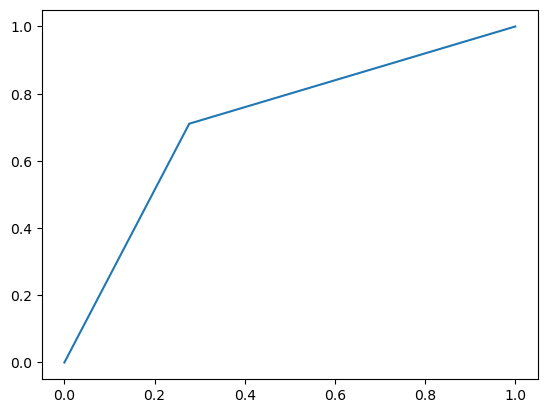

In [97]:
#Decision tree
model_pipeline2=Pipeline(
    steps=[
        ('preprocess',preprocess),
        ('model',DecisionTreeClassifier())
    ]
)
model_pipeline2.fit(train_X_under_sampled,train_y_under_sampled)
model_train_val_eval(train_X, val_X, train_y, val_y,model_pipeline2)

In [99]:
submission['Response']=model_pipeline2.predict(test)
submission.to_csv(r'C:\Users\infan\Documents\gayathri\cross_sell_prediction\csv files\decisiontree.csv',index=False)

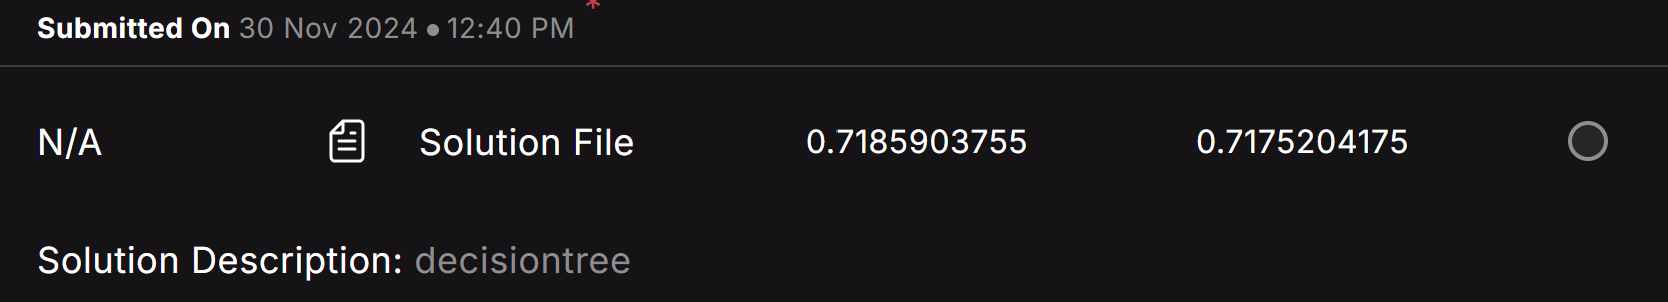

In [101]:
#decision tree with grid search cv
param1 ={'model__criterion': ['gini', 'entropy'],
    'model__max_depth':[None, 10, 20],
    'model__min_samples_split':[2,5],
    'model__max_leaf_nodes':[10,20],
    'model__min_samples_leaf':[1,2]}

grid_search1 = GridSearchCV(estimator=model_pipeline2 , param_grid=param1 , cv =5 , scoring='roc_auc')

In [103]:
grid_search1.fit(train_X_under_sampled,train_y_under_sampled)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('cat_encode',
                                                                         Pipeline(steps=[('one_hot_encoding',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Gender',
                                                                          'Vehicle_Age',
                                                                          'Vehicle_Damage']),
                                                                        ('num_encode',
                                                                         Pipeline(steps=[('standard_scalar',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Driving_License',
                                                                          'Region_Code',
                                                                          'Previously_Insured',
                                                                          'Annual_Premium',
                                                                          'Policy_Sales_Channel',
                                                                          'Vintage'])])),
                                       ('model', DecisionTreeClassifier())]),
             param_grid={'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': [None, 10, 20],
                         'model__max_leaf_nodes': [10, 20],
                         'model__min_samples_leaf': [1, 2],
                         'model__min_samples_split': [2, 5]},
             scoring='roc_auc')

In [109]:
grid_search1.best_params_

{'model__criterion': 'entropy',
 'model__max_depth': None,
 'model__max_leaf_nodes': 20,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2}

train auc
0.846029713530742
test auc
0.847608159985609
train confusion matrix
[[155747  78457]
 [  2589  29983]]
test confustion matrix
[[66941 33254]
 [ 1121 13017]]
train class matrix
              precision    recall  f1-score   support

           0       0.98      0.67      0.79    234204
           1       0.28      0.92      0.43     32572

    accuracy                           0.70    266776
   macro avg       0.63      0.79      0.61    266776
weighted avg       0.90      0.70      0.75    266776

test class matrix
              precision    recall  f1-score   support

           0       0.98      0.67      0.80    100195
           1       0.28      0.92      0.43     14138

    accuracy                           0.70    114333
   macro avg       0.63      0.79      0.61    114333
weighted avg       0.90      0.70      0.75    114333



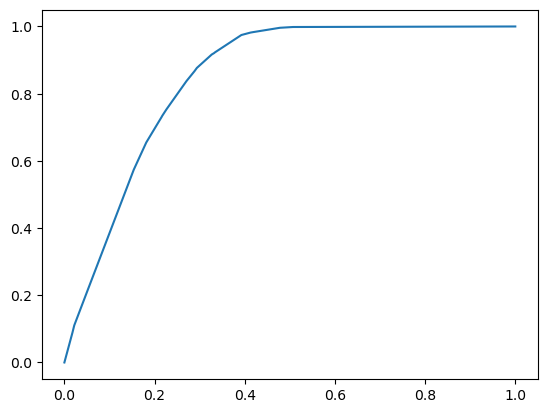

In [105]:
model2 = grid_search1.best_estimator_
model_train_val_eval(train_X, val_X, train_y, val_y,model2)

In [107]:
submission['Response']=model2.predict(test)
submission.to_csv(r'C:\Users\infan\Documents\gayathri\cross_sell_prediction\csv files\decisiontree_gridsearch.csv',index=False)

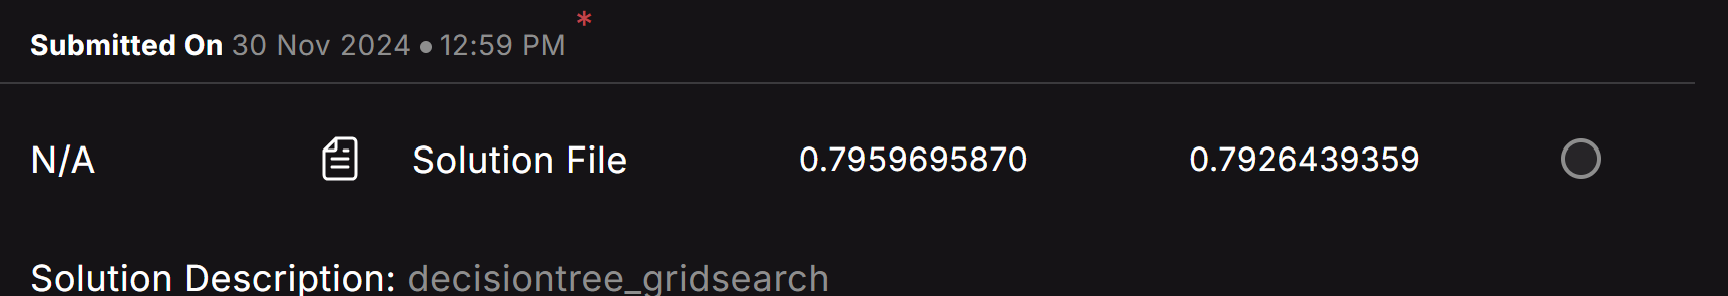

train auc
0.9651855259142119
test auc
0.8389594425119143
train confusion matrix
[[170902  63302]
 [     3  32569]]
test confustion matrix
[[69058 31137]
 [ 1737 12401]]
train class matrix
              precision    recall  f1-score   support

           0       1.00      0.73      0.84    234204
           1       0.34      1.00      0.51     32572

    accuracy                           0.76    266776
   macro avg       0.67      0.86      0.68    266776
weighted avg       0.92      0.76      0.80    266776

test class matrix
              precision    recall  f1-score   support

           0       0.98      0.69      0.81    100195
           1       0.28      0.88      0.43     14138

    accuracy                           0.71    114333
   macro avg       0.63      0.78      0.62    114333
weighted avg       0.89      0.71      0.76    114333



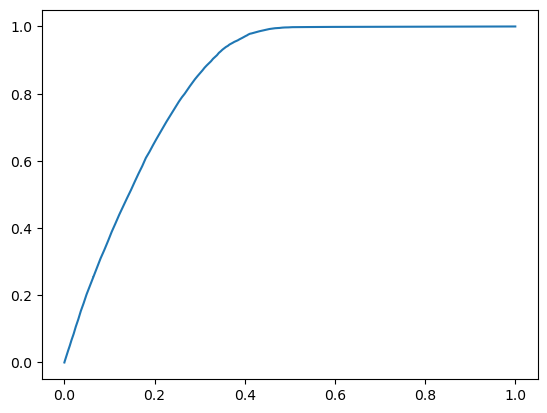

In [113]:
#Decision tree
model_pipeline3=Pipeline(
    steps=[
        ('preprocess',preprocess),
        ('model',RandomForestClassifier())
    ]
)
model_pipeline3.fit(train_X_under_sampled,train_y_under_sampled)
model_train_val_eval(train_X, val_X, train_y, val_y,model_pipeline3)

In [115]:
submission['Response']=model_pipeline3.predict(test)
submission.to_csv(r'C:\Users\infan\Documents\gayathri\cross_sell_prediction\csv files\randomforest.csv',index=False)

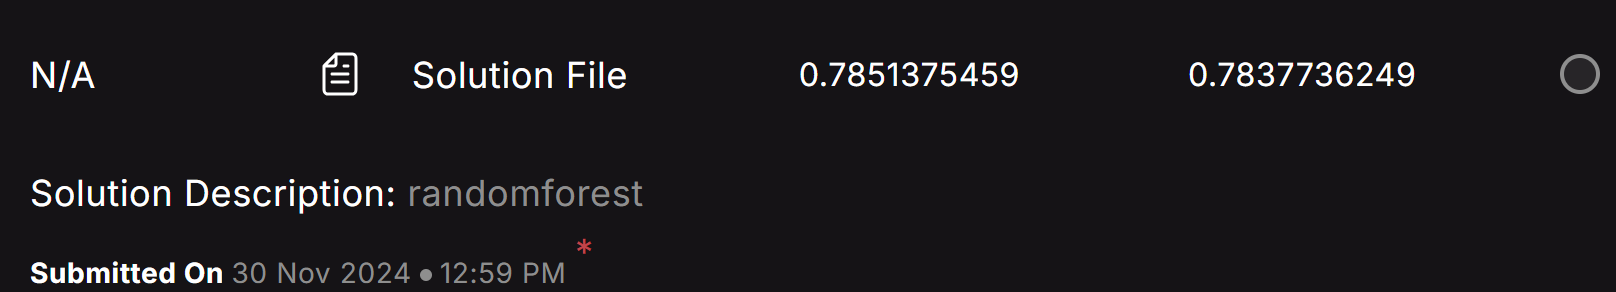

In [118]:
#randomforest - grid search
#randomforest with grid search cv
param3 ={'model__criterion': ['gini', 'entropy'],
    'model__max_depth':[None, 10, 20],
    'model__min_samples_split':[2,5],
    'model__max_leaf_nodes':[10,20],
    'model__min_samples_leaf':[1,2]}

grid_search3 = GridSearchCV(estimator=model_pipeline3 , param_grid=param3 , cv =5 , scoring='roc_auc')
grid_search3.fit(train_X_under_sampled,train_y_under_sampled)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('cat_encode',
                                                                         Pipeline(steps=[('one_hot_encoding',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Gender',
                                                                          'Vehicle_Age',
                                                                          'Vehicle_Damage']),
                                                                        ('num_encode',
                                                                         Pipeline(steps=[('standard_scalar',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Driving_License',
                                                                          'Region_Code',
                                                                          'Previously_Insured',
                                                                          'Annual_Premium',
                                                                          'Policy_Sales_Channel',
                                                                          'Vintage'])])),
                                       ('model', RandomForestClassifier())]),
             param_grid={'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': [None, 10, 20],
                         'model__max_leaf_nodes': [10, 20],
                         'model__min_samples_leaf': [1, 2],
                         'model__min_samples_split': [2, 5]},
             scoring='roc_auc')

In [122]:
grid_search3.best_params_

{'model__criterion': 'gini',
 'model__max_depth': 20,
 'model__max_leaf_nodes': 20,
 'model__min_samples_leaf': 2,
 'model__min_samples_split': 2}

train auc
0.849673176418728
test auc
0.8505530324934139
train confusion matrix
[[152278  81926]
 [  2028  30544]]
test confustion matrix
[[65460 34735]
 [  858 13280]]
train class matrix
              precision    recall  f1-score   support

           0       0.99      0.65      0.78    234204
           1       0.27      0.94      0.42     32572

    accuracy                           0.69    266776
   macro avg       0.63      0.79      0.60    266776
weighted avg       0.90      0.69      0.74    266776

test class matrix
              precision    recall  f1-score   support

           0       0.99      0.65      0.79    100195
           1       0.28      0.94      0.43     14138

    accuracy                           0.69    114333
   macro avg       0.63      0.80      0.61    114333
weighted avg       0.90      0.69      0.74    114333



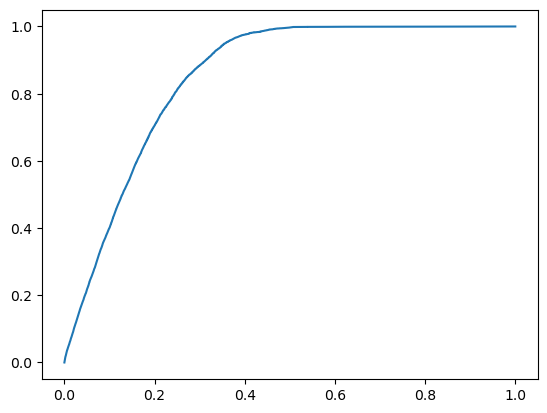

In [124]:
model3 = grid_search3.best_estimator_
model_train_val_eval(train_X, val_X, train_y, val_y,model3)

In [126]:
submission['Response']=model3.predict(test)
submission.to_csv(r'C:\Users\infan\Documents\gayathri\cross_sell_prediction\csv files\randomforest_gridsearch.csv',index=False)

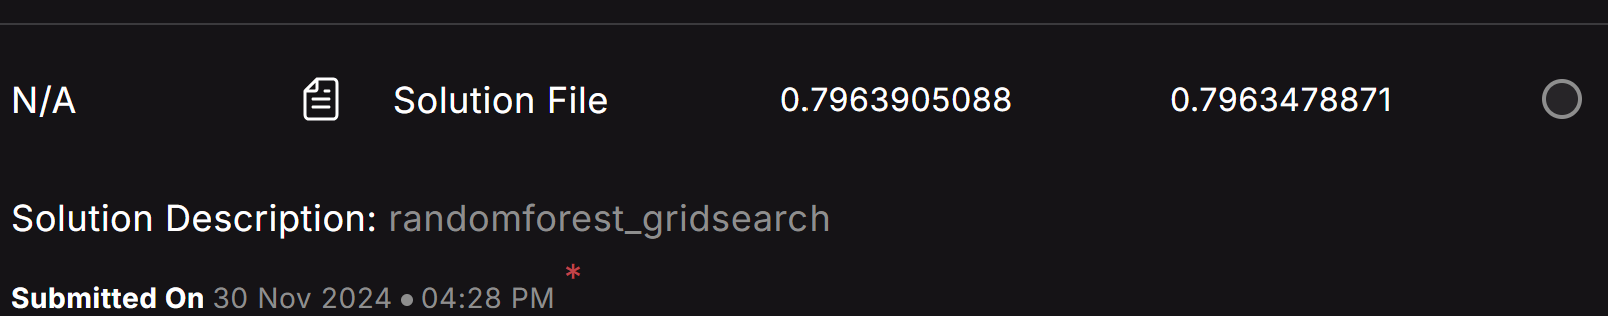

train auc
0.8559025041435551
test auc
0.8570362718431129
train confusion matrix
[[155057  79147]
 [  2164  30408]]
test confustion matrix
[[66619 33576]
 [  935 13203]]
train class matrix
              precision    recall  f1-score   support

           0       0.99      0.66      0.79    234204
           1       0.28      0.93      0.43     32572

    accuracy                           0.70    266776
   macro avg       0.63      0.80      0.61    266776
weighted avg       0.90      0.70      0.75    266776

test class matrix
              precision    recall  f1-score   support

           0       0.99      0.66      0.79    100195
           1       0.28      0.93      0.43     14138

    accuracy                           0.70    114333
   macro avg       0.63      0.80      0.61    114333
weighted avg       0.90      0.70      0.75    114333



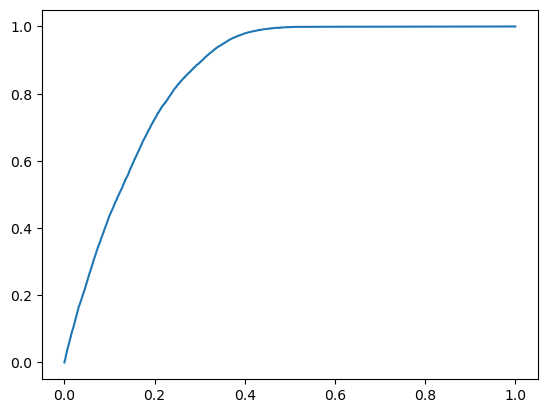

In [128]:
#Decision tree
model_pipeline4=Pipeline(
    steps=[
        ('preprocess',preprocess),
        ('model',GradientBoostingClassifier())
    ]
)
model_pipeline4.fit(train_X_under_sampled,train_y_under_sampled)
model_train_val_eval(train_X, val_X, train_y, val_y,model_pipeline4)

In [130]:
submission['Response']=model_pipeline4.predict(test)
submission.to_csv(r'C:\Users\infan\Documents\gayathri\cross_sell_prediction\csv files\gradientboosting.csv',index=False)

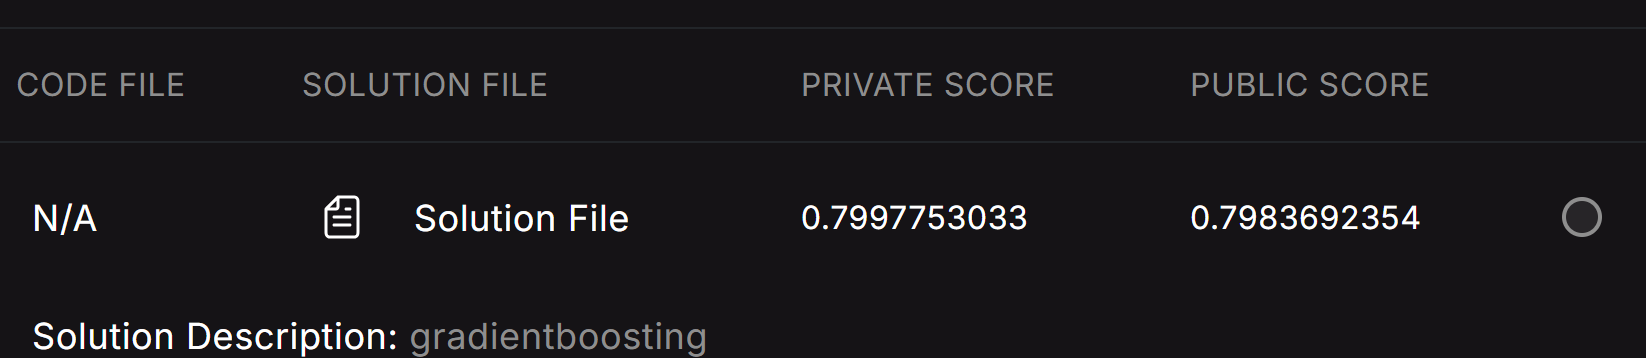

In [134]:
params4 = {
    'model__criterion': ['friedman_mse', 'squared_error'],
    'model__max_depth':[None, 10, 20],
    'model__min_samples_split':[2,5],
    'model__max_leaf_nodes':[10,20],
    'model__min_samples_leaf':[1,2]
    }
grid_search4 = GridSearchCV(estimator=model_pipeline4 , param_grid=params4 , cv =5 , scoring='roc_auc')
grid_search4.fit(train_X_under_sampled,train_y_under_sampled)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('cat_encode',
                                                                         Pipeline(steps=[('one_hot_encoding',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Gender',
                                                                          'Vehicle_Age',
                                                                          'Vehicle_Damage']),
                                                                        ('num_encode',
                                                                         Pipeline(steps=[('standard_scalar',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Driving_License',
                                                                          'Region_Code',
                                                                          'Previously_Insured',
                                                                          'Annual_Premium',
                                                                          'Policy_Sales_Channel',
                                                                          'Vintage'])])),
                                       ('model',
                                        GradientBoostingClassifier())]),
             param_grid={'model__criterion': ['friedman_mse', 'squared_error'],
                         'model__max_depth': [None, 10, 20],
                         'model__max_leaf_nodes': [10, 20],
                         'model__min_samples_leaf': [1, 2],
                         'model__min_samples_split': [2, 5]},
             scoring='roc_auc')

In [136]:
grid_search4.best_params_

{'model__criterion': 'friedman_mse',
 'model__max_depth': None,
 'model__max_leaf_nodes': 20,
 'model__min_samples_leaf': 2,
 'model__min_samples_split': 5}

train auc
0.8605365812733148
test auc
0.8580735125565835
train confusion matrix
[[156972  77232]
 [  2034  30538]]
test confustion matrix
[[67364 32831]
 [  977 13161]]
train class matrix
              precision    recall  f1-score   support

           0       0.99      0.67      0.80    234204
           1       0.28      0.94      0.44     32572

    accuracy                           0.70    266776
   macro avg       0.64      0.80      0.62    266776
weighted avg       0.90      0.70      0.75    266776

test class matrix
              precision    recall  f1-score   support

           0       0.99      0.67      0.80    100195
           1       0.29      0.93      0.44     14138

    accuracy                           0.70    114333
   macro avg       0.64      0.80      0.62    114333
weighted avg       0.90      0.70      0.75    114333



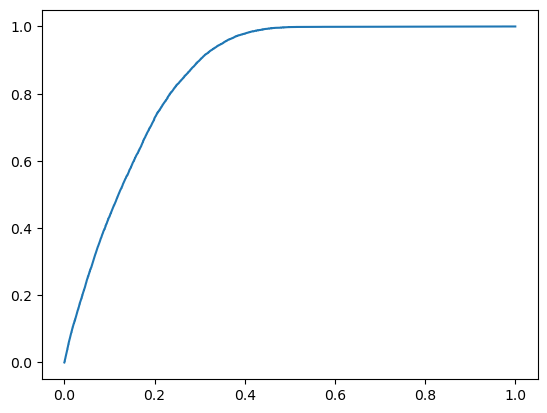

In [138]:
model4 = grid_search4.best_estimator_
model_train_val_eval(train_X, val_X, train_y, val_y,model4)

In [140]:
submission['Response']=model4.predict(test)
submission.to_csv(r'C:\Users\infan\Documents\gayathri\cross_sell_prediction\csv files\gradientboosting_gridsearch.csv',index=False)

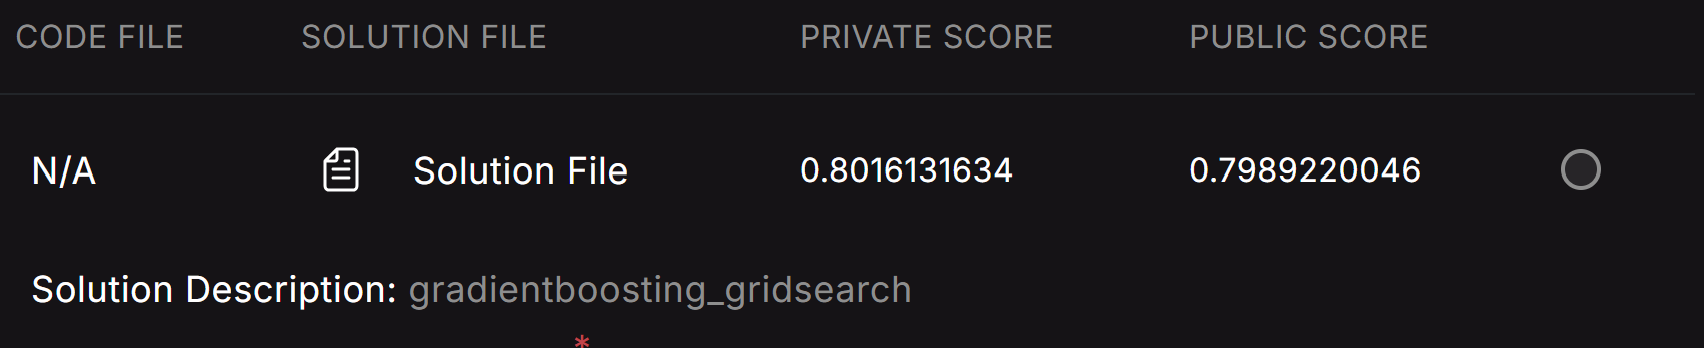

train auc
0.8512701023119864
test auc
0.8527915733367889
train confusion matrix
[[153236  80968]
 [  2051  30521]]
test confustion matrix
[[65770 34425]
 [  891 13247]]
train class matrix
              precision    recall  f1-score   support

           0       0.99      0.65      0.79    234204
           1       0.27      0.94      0.42     32572

    accuracy                           0.69    266776
   macro avg       0.63      0.80      0.61    266776
weighted avg       0.90      0.69      0.74    266776

test class matrix
              precision    recall  f1-score   support

           0       0.99      0.66      0.79    100195
           1       0.28      0.94      0.43     14138

    accuracy                           0.69    114333
   macro avg       0.63      0.80      0.61    114333
weighted avg       0.90      0.69      0.74    114333



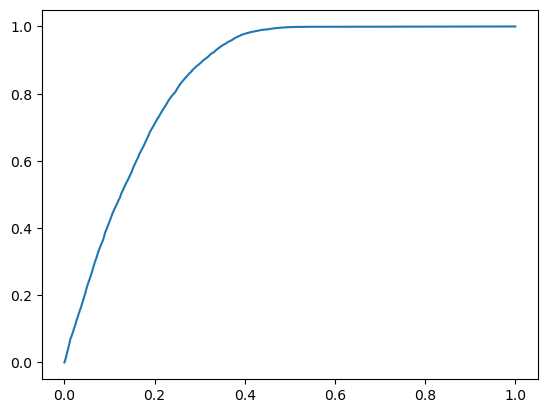

In [151]:
#Decision tree
model_pipeline5=Pipeline(
    steps=[
        ('preprocess',preprocess),
        ('model',AdaBoostClassifier())
    ]
)
model_pipeline5.fit(train_X_under_sampled,train_y_under_sampled)
model_train_val_eval(train_X, val_X, train_y, val_y,model_pipeline5)

In [153]:
submission['Response']=model_pipeline5.predict(test)
submission.to_csv(r'C:\Users\infan\Documents\gayathri\cross_sell_prediction\csv files\Adaboost.csv',index=False)

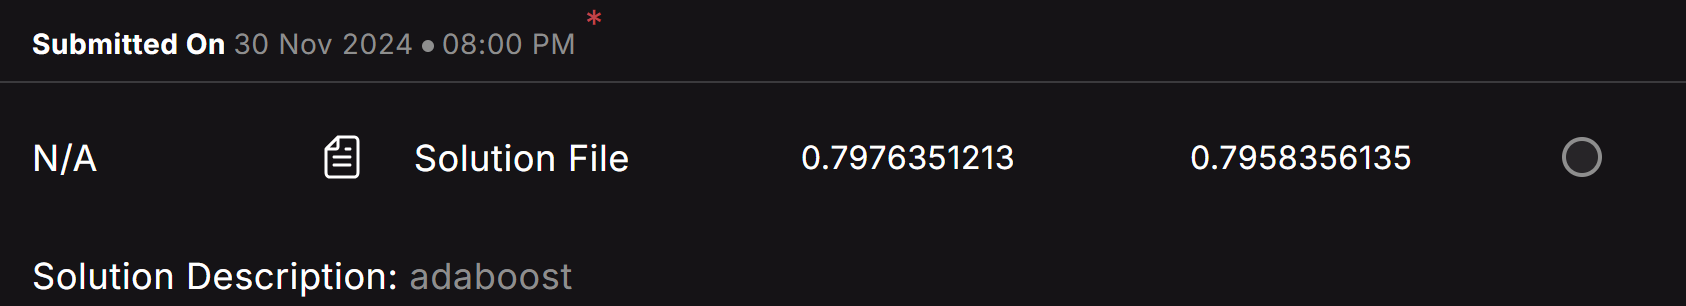

In [198]:
params5 = {
    'model__n_estimators': [50, 100, 200, 300],
    'model__learning_rate': [0.01, 0.1, 0.5, 1.0],
    'model__estimator': [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2)]
}

grid_search5 = GridSearchCV(estimator=model_pipeline5 , param_grid=params5 , cv =5 , scoring='roc_auc',n_jobs=-1)
grid_search5.fit(train_X_under_sampled,train_y_under_sampled)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('cat_encode',
                                                                         Pipeline(steps=[('one_hot_encoding',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Gender',
                                                                          'Vehicle_Age',
                                                                          'Vehicle_Damage']),
                                                                        ('num_encode',
                                                                         Pipeline(steps=[('standard_scalar',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Driving_License',
                                                                          'Region_Code',
                                                                          'Previously_Insured',
                                                                          'Annual_Premium',
                                                                          'Policy_Sales_Channel',
                                                                          'Vintage'])])),
                                       ('model', AdaBoostClassifier())]),
             n_jobs=-1,
             param_grid={'model__estimator': [DecisionTreeClassifier(max_depth=1),
                                              DecisionTreeClassifier(max_depth=2)],
                         'model__learning_rate': [0.01, 0.1, 0.5, 1.0],
                         'model__n_estimators': [50, 100, 200, 300]},
             scoring='roc_auc')

In [200]:
grid_search5.best_params_

{'model__estimator': DecisionTreeClassifier(max_depth=2),
 'model__learning_rate': 0.1,
 'model__n_estimators': 300}

train auc
0.856177237054199
test auc
0.8566455250993057
train confusion matrix
[[155825  78379]
 [  2234  30338]]
test confustion matrix
[[66907 33288]
 [  974 13164]]
train class matrix
              precision    recall  f1-score   support

           0       0.99      0.67      0.79    234204
           1       0.28      0.93      0.43     32572

    accuracy                           0.70    266776
   macro avg       0.63      0.80      0.61    266776
weighted avg       0.90      0.70      0.75    266776

test class matrix
              precision    recall  f1-score   support

           0       0.99      0.67      0.80    100195
           1       0.28      0.93      0.43     14138

    accuracy                           0.70    114333
   macro avg       0.63      0.80      0.62    114333
weighted avg       0.90      0.70      0.75    114333



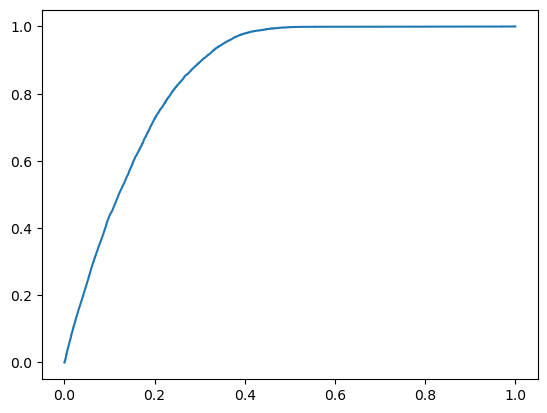

In [202]:
model5 = grid_search5.best_estimator_
model_train_val_eval(train_X, val_X, train_y, val_y,model5)

In [204]:
submission['Response']=model5.predict(test)
submission.to_csv(r'C:\Users\infan\Documents\gayathri\cross_sell_prediction\csv files\adaboost_gridsearch.csv',index=False)

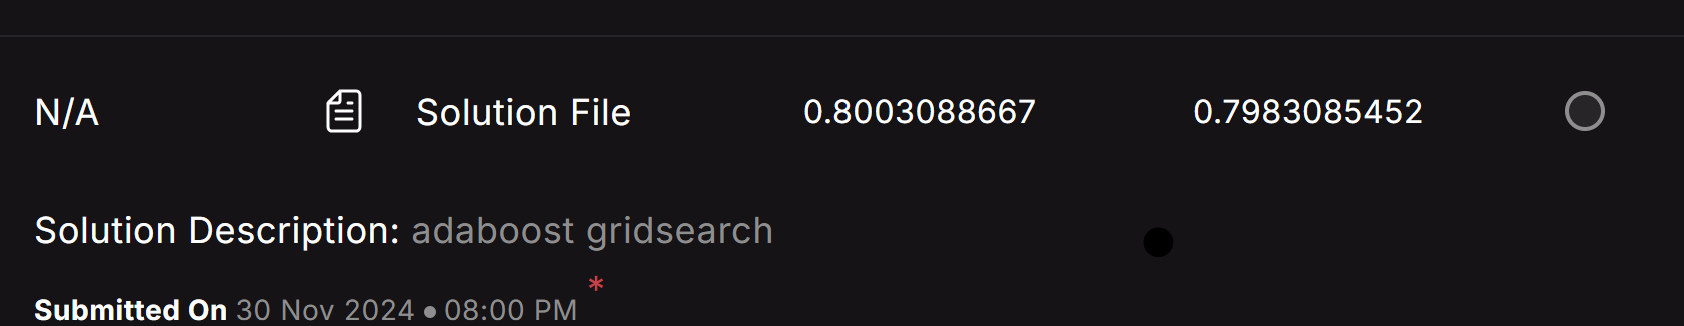

train auc
0.8706390733581837
test auc
0.85288871415692
train confusion matrix
[[158962  75242]
 [  1743  30829]]
test confustion matrix
[[67832 32363]
 [ 1153 12985]]
train class matrix
              precision    recall  f1-score   support

           0       0.99      0.68      0.81    234204
           1       0.29      0.95      0.44     32572

    accuracy                           0.71    266776
   macro avg       0.64      0.81      0.62    266776
weighted avg       0.90      0.71      0.76    266776

test class matrix
              precision    recall  f1-score   support

           0       0.98      0.68      0.80    100195
           1       0.29      0.92      0.44     14138

    accuracy                           0.71    114333
   macro avg       0.63      0.80      0.62    114333
weighted avg       0.90      0.71      0.76    114333



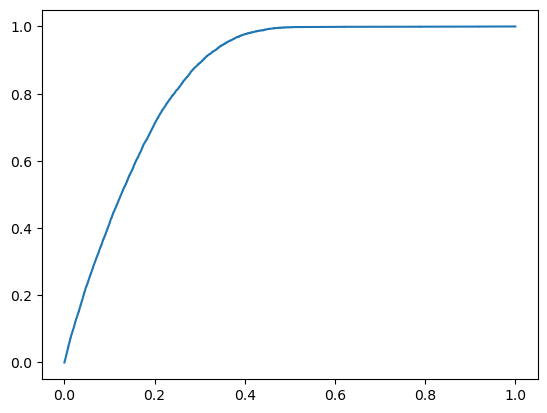

In [212]:
model_pipeline6 = Pipeline(
    steps=[
        ('preprocess', preprocess),
        ('model', XGBClassifier())
    ]
)
model_pipeline6.fit(train_X_under_sampled,train_y_under_sampled)
model_train_val_eval(train_X, val_X, train_y, val_y,model_pipeline6)


In [214]:
submission['Response']=model_pipeline6.predict(test)
submission.to_csv(r'C:\Users\infan\Documents\gayathri\cross_sell_prediction\csv files\XGboost.csv',index=False)

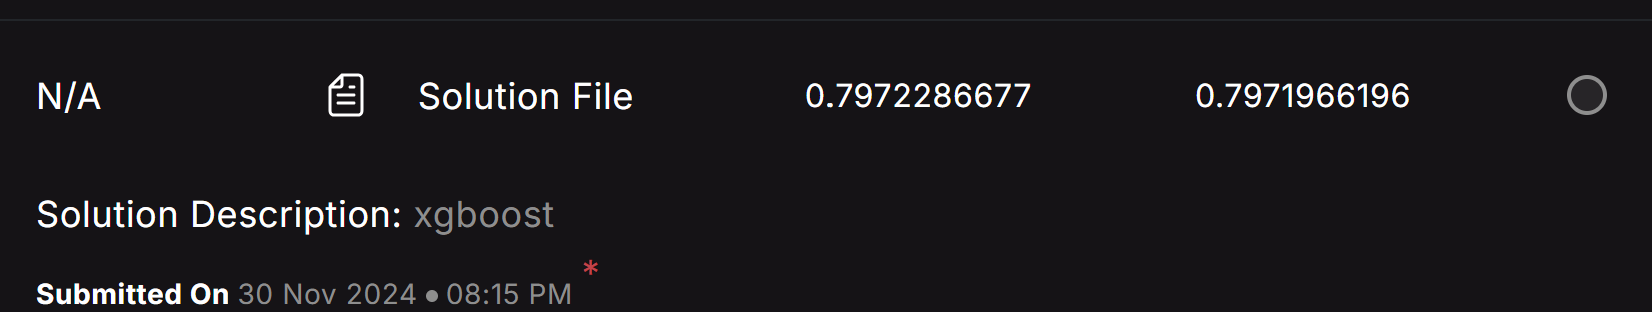

In [217]:
params = {
    'model__n_estimators': [50, 100, 200],  # Number of trees in the forest
    'model__max_depth': [3, 5, 7],          # Maximum tree depth
    'model__learning_rate': [0.01, 0.1, 0.2],  # Step size shrinkage
    'model__subsample': [0.6, 0.8, 1.0],    # Fraction of samples used per tree
    'model__colsample_bytree': [0.6, 0.8, 1.0],  # Fraction of features per tree
    'model__gamma': [0, 0.1, 0.2],          # Minimum loss reduction to split a node
    'model__scale_pos_weight': [1, 2, 5]    # Balances positive and negative classes
}
grid_search6= GridSearchCV(estimator=model_pipeline6,param_grid=params,scoring='roc_auc',cv=7,n_jobs=-1)
grid_search6.fit(train_X_under_sampled,train_y_under_sampled)

GridSearchCV(cv=7,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('cat_encode',
                                                                         Pipeline(steps=[('one_hot_encoding',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Gender',
                                                                          'Vehicle_Age',
                                                                          'Vehicle_Damage']),
                                                                        ('num_encode',
                                                                         Pipeline(steps=[('standard_scalar',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Driving_License',
                                                                          'Region_Code',
                                                                          'Previously_Insur...
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'model__colsample_bytree': [0.6, 0.8, 1.0],
                         'model__gamma': [0, 0.1, 0.2],
                         'model__learning_rate': [0.01, 0.1, 0.2],
                         'model__max_depth': [3, 5, 7],
                         'model__n_estimators': [50, 100, 200],
                         'model__scale_pos_weight': [1, 2, 5],
                         'model__subsample': [0.6, 0.8, 1.0]},
             scoring='roc_auc')

In [219]:
grid_search6.best_params_

{'model__colsample_bytree': 0.6,
 'model__gamma': 0.1,
 'model__learning_rate': 0.1,
 'model__max_depth': 7,
 'model__n_estimators': 50,
 'model__scale_pos_weight': 2,
 'model__subsample': 1.0}

train auc
0.8614881690635765
test auc
0.8581814817450575
train confusion matrix
[[142345  91859]
 [   687  31885]]
test confustion matrix
[[61059 39136]
 [  352 13786]]
train class matrix
              precision    recall  f1-score   support

           0       1.00      0.61      0.75    234204
           1       0.26      0.98      0.41     32572

    accuracy                           0.65    266776
   macro avg       0.63      0.79      0.58    266776
weighted avg       0.91      0.65      0.71    266776

test class matrix
              precision    recall  f1-score   support

           0       0.99      0.61      0.76    100195
           1       0.26      0.98      0.41     14138

    accuracy                           0.65    114333
   macro avg       0.63      0.79      0.58    114333
weighted avg       0.90      0.65      0.71    114333



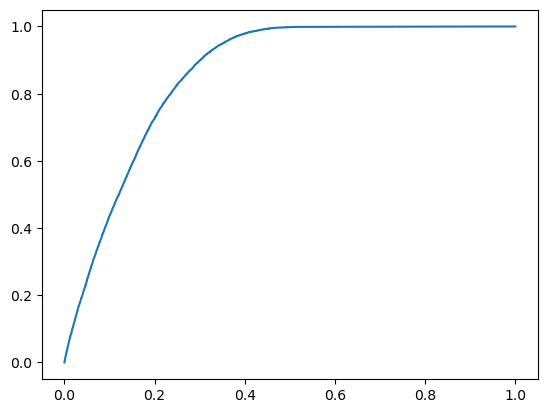

In [221]:
model6 = grid_search6.best_estimator_
model_train_val_eval(train_X, val_X, train_y, val_y,model6)

In [223]:
submission['Response']=model6.predict(test)
submission.to_csv(r'C:\Users\infan\Documents\gayathri\cross_sell_prediction\csv files\XGboost_gridsearch.csv',index=False)

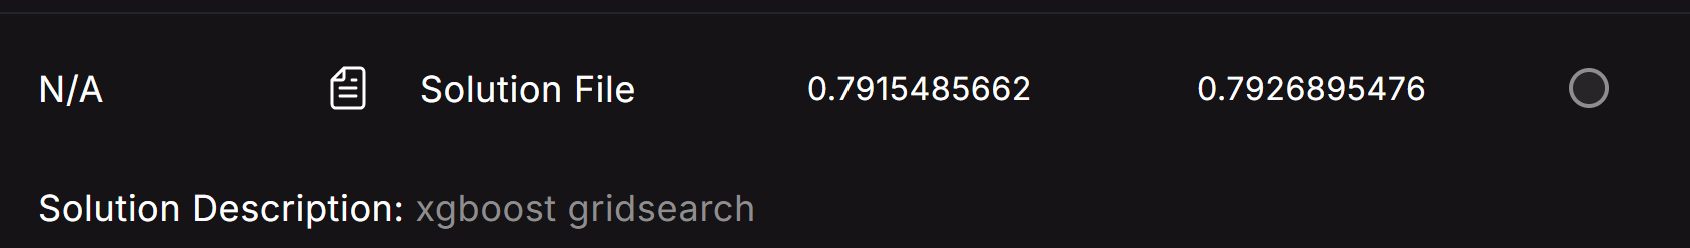

train auc
0.8679052985676796
test auc
0.8568051773507638
train confusion matrix
[[157936  76268]
 [  1918  30654]]
test confustion matrix
[[67585 32610]
 [ 1029 13109]]
train class matrix
              precision    recall  f1-score   support

           0       0.99      0.67      0.80    234204
           1       0.29      0.94      0.44     32572

    accuracy                           0.71    266776
   macro avg       0.64      0.81      0.62    266776
weighted avg       0.90      0.71      0.76    266776

test class matrix
              precision    recall  f1-score   support

           0       0.99      0.67      0.80    100195
           1       0.29      0.93      0.44     14138

    accuracy                           0.71    114333
   macro avg       0.64      0.80      0.62    114333
weighted avg       0.90      0.71      0.76    114333



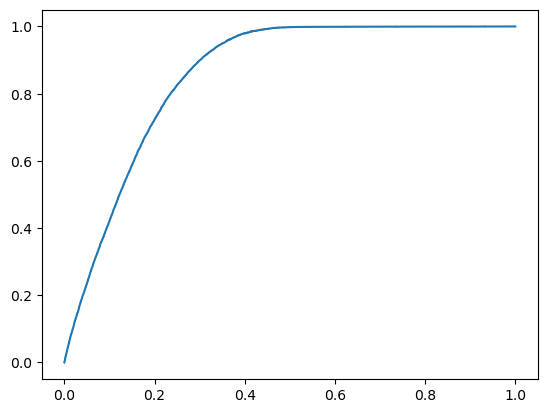

In [240]:

model_pipeline7 = Pipeline(
    steps=[
        ('preprocess', preprocess),
        ('model', XGBClassifier(
            n_estimators=1000,  
            learning_rate=0.04,  
            max_depth=6,  
            subsample=0.9,  
            colsample_bytree=0.35, 
            scale_pos_weight=1,  
            random_state=1,
            gamma  = 0.4,
            reg_alpha=0.05,   
            reg_lambda=1.0   
        ))
    ]
)
model_pipeline7.fit(train_X_under_sampled,train_y_under_sampled)
model_train_val_eval(train_X, val_X, train_y, val_y,model_pipeline7)


In [242]:
submission['Response']=model_pipeline7.predict(test)
submission.to_csv(r'C:\Users\infan\Documents\gayathri\cross_sell_prediction\csv files\XGboost2.csv',index=False)

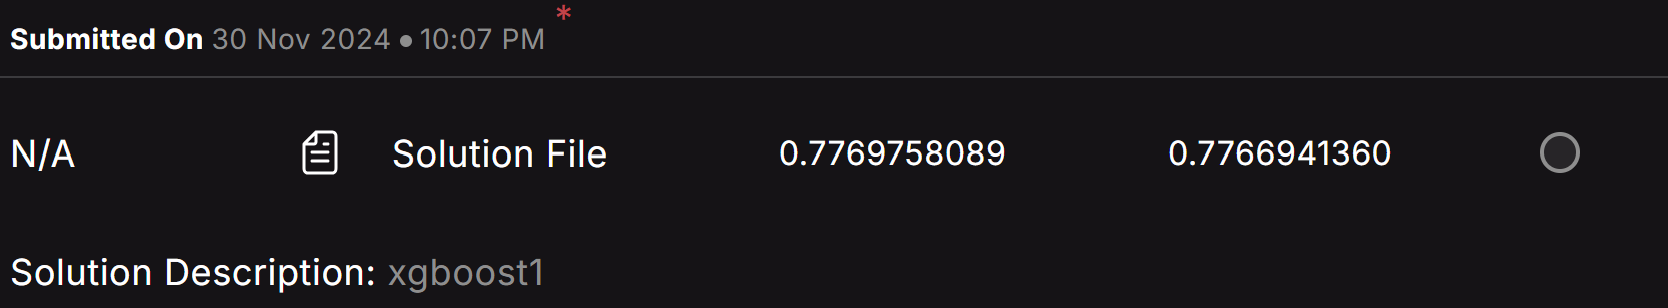

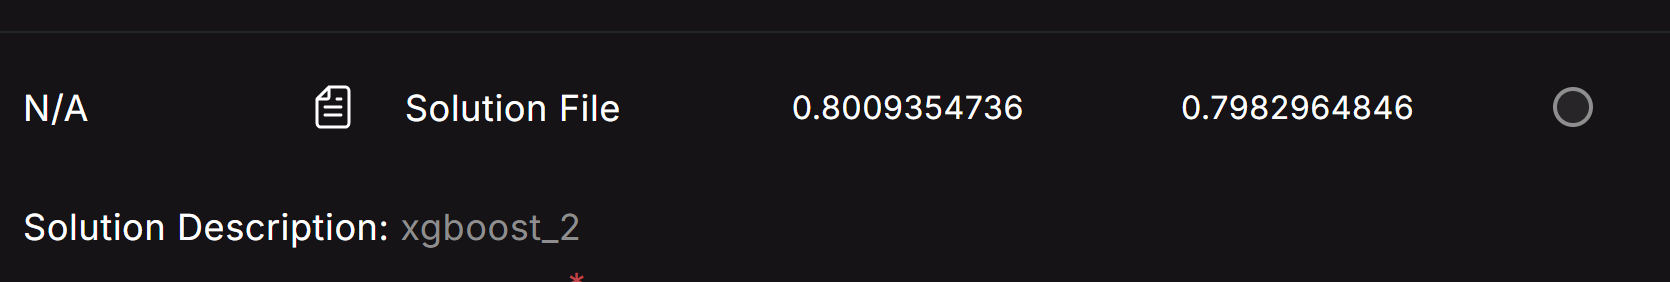

[LightGBM] [Info] Number of positive: 32572, number of negative: 32572
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 749
[LightGBM] [Info] Number of data points in the train set: 65144, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
train auc
0.8626191443889604
test auc
0.8578027715808467
train confusion matrix
[[156055  78149]
 [  1927  30645]]
test confustion matrix
[[66999 33196]
 [  913 13225]]
train class matrix
              precision    recall  f1-score   support

           0       0.99      0.67      0.80    234204
           1       0.28      0.94      0.43     32572

    accuracy                           0.70    266776
   macro avg       0.63      0.80      0.61    266776
weighted avg       0.90      0.70     

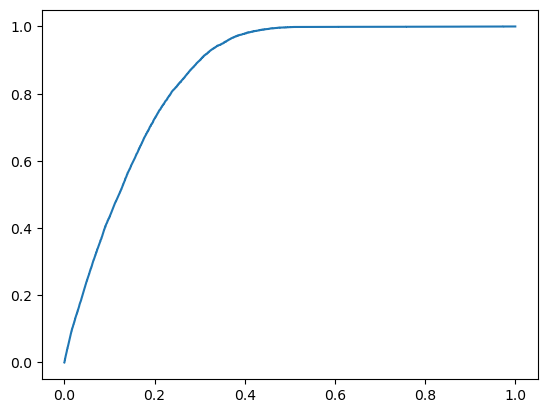

In [256]:

model_pipeline7 = Pipeline(
    steps=[
        ('preprocess', preprocess),
        ('model', lgb.LGBMClassifier())
    ]
)
model_pipeline7.fit(train_X_under_sampled,train_y_under_sampled)
model_train_val_eval(train_X, val_X, train_y, val_y,model_pipeline7)

In [258]:
submission['Response']=model_pipeline7.predict(test)
submission.to_csv(r'C:\Users\infan\Documents\gayathri\cross_sell_prediction\csv files\llgbm classifier.csv',index=False)

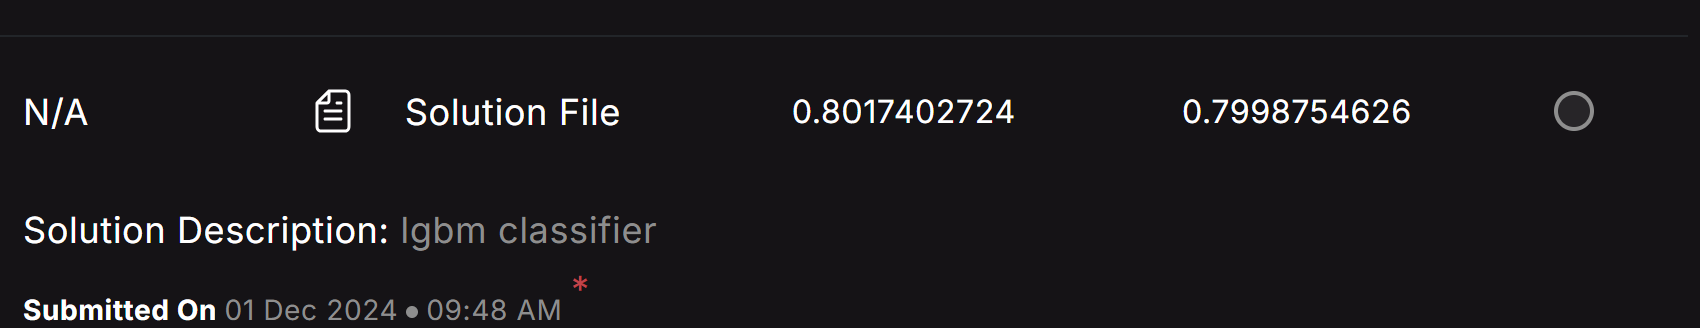

train auc
0.8626191443889604
test auc
0.8578027715808467
train confusion matrix
[[156055  78149]
 [  1927  30645]]
test confustion matrix
[[66999 33196]
 [  913 13225]]
train class matrix
              precision    recall  f1-score   support

           0       0.99      0.67      0.80    234204
           1       0.28      0.94      0.43     32572

    accuracy                           0.70    266776
   macro avg       0.63      0.80      0.61    266776
weighted avg       0.90      0.70      0.75    266776

test class matrix
              precision    recall  f1-score   support

           0       0.99      0.67      0.80    100195
           1       0.28      0.94      0.44     14138

    accuracy                           0.70    114333
   macro avg       0.64      0.80      0.62    114333
weighted avg       0.90      0.70      0.75    114333



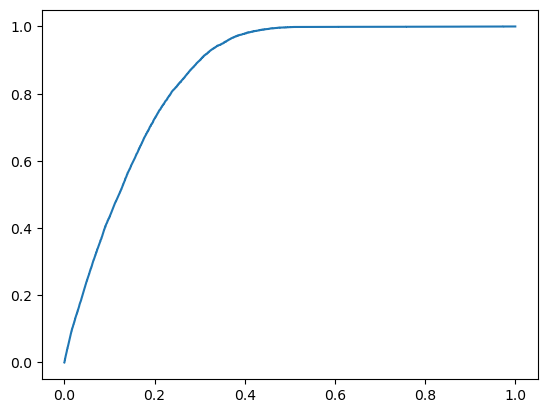

In [261]:

model_pipeline8 = Pipeline(
    steps=[
        ('preprocess', preprocess),
        ('model', XGBClassifier(
            n_estimators=1000,  
            learning_rate=0.05,  
            max_depth=6,  
            subsample=0.9,  
            colsample_bytree=0.35, 
            scale_pos_weight=1,  
            random_state=1  
        ))
    ]
)
model_pipeline8.fit(train_X_under_sampled,train_y_under_sampled)
model_train_val_eval(train_X, val_X, train_y, val_y,model_pipeline7)


In [263]:
submission['Response']=model_pipeline8.predict(test)
submission.to_csv(r'C:\Users\infan\Documents\gayathri\cross_sell_prediction\csv files\XGboost3.csv',index=False)

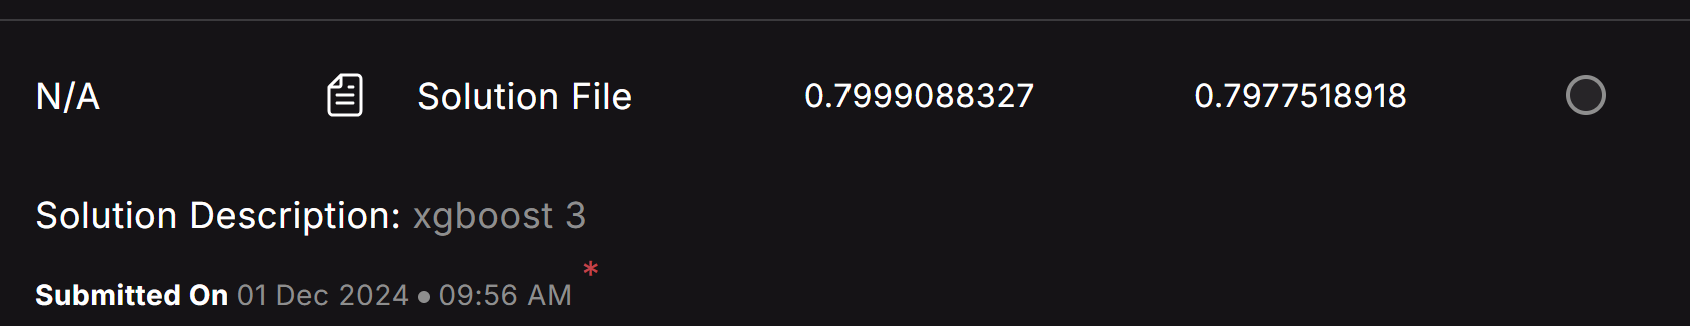

train auc
0.8550685608915667
test auc
0.846839752100041
train confusion matrix
[[198072  36132]
 [ 13374  19198]]
test confustion matrix
[[84454 15741]
 [ 6125  8013]]
train class matrix
              precision    recall  f1-score   support

           0       0.94      0.85      0.89    234204
           1       0.35      0.59      0.44     32572

    accuracy                           0.81    266776
   macro avg       0.64      0.72      0.66    266776
weighted avg       0.86      0.81      0.83    266776

test class matrix
              precision    recall  f1-score   support

           0       0.93      0.84      0.89    100195
           1       0.34      0.57      0.42     14138

    accuracy                           0.81    114333
   macro avg       0.63      0.70      0.65    114333
weighted avg       0.86      0.81      0.83    114333



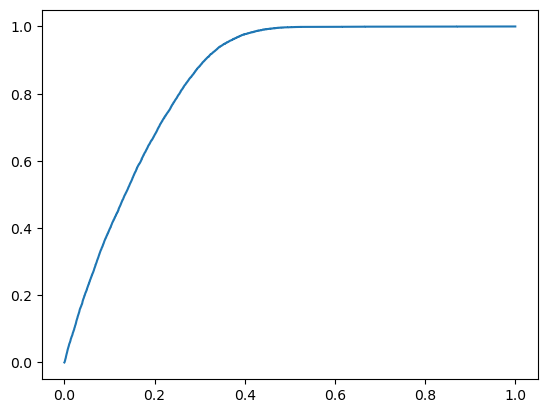

In [293]:
#xgboost
from imblearn.pipeline import Pipeline  # Import Pipeline from imblearn

smote= SMOTE(random_state=2)

classifier = XGBClassifier(
    n_estimators=1000,  # Number of boosting rounds
    learning_rate=0.05,  # Learning rate
    max_depth=5,  # Maximum depth of each tree
    subsample=0.6,  # Subsample ratio
    colsample_bytree=0.6,  # Feature subsampling ratio
    scale_pos_weight=1,  # Adjust for imbalance
    gamma  = 0.4,
    reg_alpha=0.05,   # Add L1 regularization
    reg_lambda=1.0   # Add L2 regularization
)

# Create pipeline
model_pipeline9 = Pipeline(
    steps=[
        ('preprocess',preprocess),
        ('smote', smote),  # Balance classes using SMOTE
        ('classifier', classifier)  # Classifier
    ]
)
model_pipeline9.fit(train_X,train_y)
model_train_val_eval(train_X, val_X, train_y, val_y,model_pipeline9)

In [289]:
submission['Response']=model_pipeline9.predict(test)
submission.to_csv(r'C:\Users\infan\Documents\gayathri\cross_sell_prediction\csv files\XGboost4.csv',index=False)

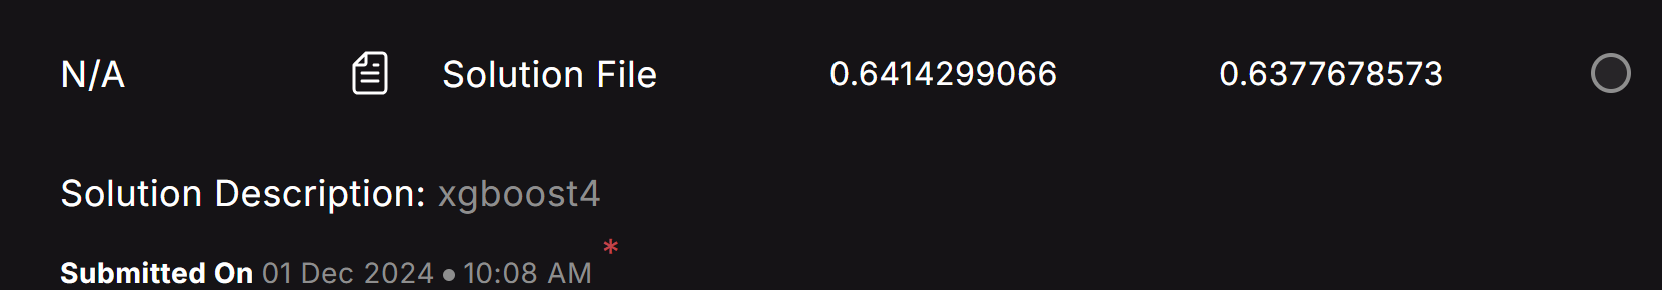

0:	learn: 0.6740480	total: 40.6ms	remaining: 6m 45s
1000:	learn: 0.2149480	total: 46.3s	remaining: 6m 56s
2000:	learn: 0.1913895	total: 1m 33s	remaining: 6m 14s
3000:	learn: 0.1834163	total: 2m 23s	remaining: 5m 35s
4000:	learn: 0.1779835	total: 3m 13s	remaining: 4m 50s
5000:	learn: 0.1734385	total: 3m 59s	remaining: 3m 59s
6000:	learn: 0.1694026	total: 4m 46s	remaining: 3m 10s
7000:	learn: 0.1657222	total: 5m 35s	remaining: 2m 23s
8000:	learn: 0.1623745	total: 6m 19s	remaining: 1m 34s
9000:	learn: 0.1592456	total: 7m 6s	remaining: 47.3s
9999:	learn: 0.1562493	total: 7m 54s	remaining: 0us
train auc
0.9119635409028526
test auc
0.8498027354227511
train confusion matrix
[[224935   9269]
 [ 20087  12485]]
test confustion matrix
[[94851  5344]
 [10775  3363]]
train class matrix
              precision    recall  f1-score   support

           0       0.92      0.96      0.94    234204
           1       0.57      0.38      0.46     32572

    accuracy                           0.89    26677

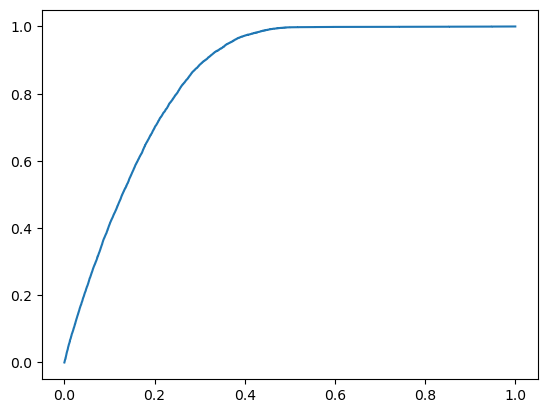

In [312]:
from catboost import CatBoostClassifier  # Import CatBoost Classifier
from imblearn.pipeline import Pipeline  # Import Pipeline from imblearn

# Define the CatBoostClassifier
classifier = CatBoostClassifier(
    iterations=10000,  # Number of boosting rounds
    learning_rate=0.02,  # Learning rate
    depth=8,  # Maximum depth of each tree
    subsample=0.6,  # Subsample ratio
    rsm=0.8,  # Feature subsampling ratio
    scale_pos_weight=1,  # Adjust for imbalance
    l2_leaf_reg=1.0,  # L2 regularization
    cat_features=[],  # Specify categorical feature indices if required
    verbose=1000  # Set verbosity to track progress
)

# Create pipeline
model_pipeline10 = Pipeline(
    steps=[
        ('preprocess', preprocess),
        ('smote', smote),  # Balance classes using SMOTE
        ('classifier', classifier)  # Classifier
    ]
)

# Train the pipeline
model_pipeline10.fit(train_X, train_y)

# Evaluate the pipeline
model_train_val_eval(train_X, val_X, train_y, val_y, model_pipeline10)


In [314]:
submission['Response']=model_pipeline10.predict(test)
submission.to_csv(r'C:\Users\infan\Documents\gayathri\cross_sell_prediction\csv files\catboost1.csv',index=False)

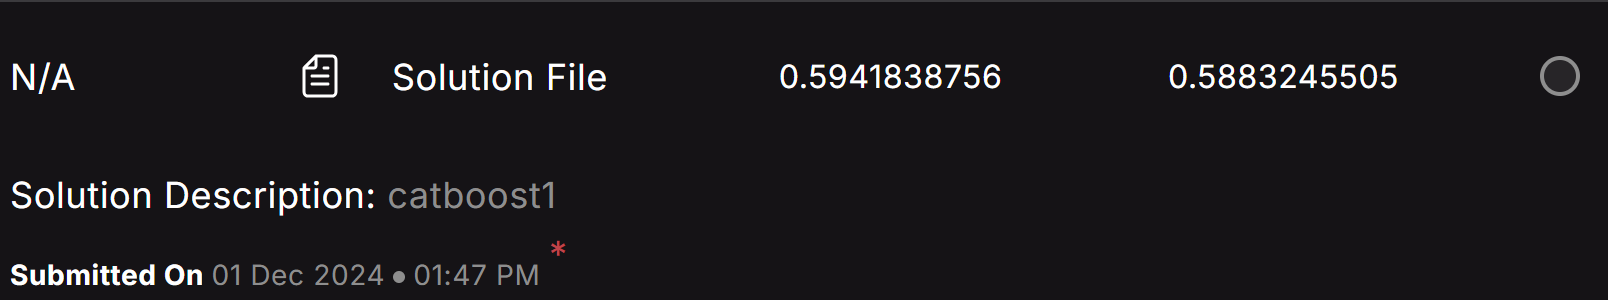

train auc
0.8645631462456428
test auc
0.8644434349900485
train confusion matrix
[[180385  87134]
 [  2351  35017]]
test confustion matrix
[[45136 21744]
 [  596  8746]]
train class matrix
              precision    recall  f1-score   support

           0       0.99      0.67      0.80    267519
           1       0.29      0.94      0.44     37368

    accuracy                           0.71    304887
   macro avg       0.64      0.81      0.62    304887
weighted avg       0.90      0.71      0.76    304887

test class matrix
              precision    recall  f1-score   support

           0       0.99      0.67      0.80     66880
           1       0.29      0.94      0.44      9342

    accuracy                           0.71     76222
   macro avg       0.64      0.81      0.62     76222
weighted avg       0.90      0.71      0.76     76222



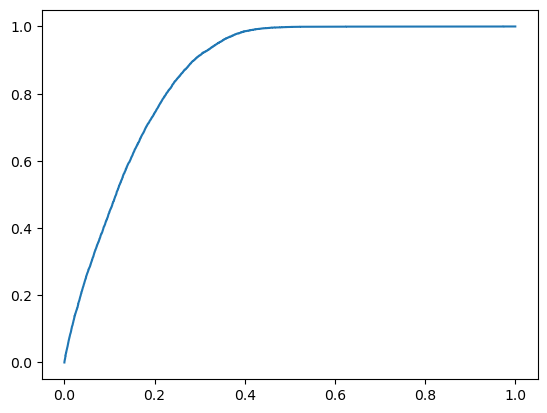

In [316]:
smote = SMOTE(random_state=2)
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

model_pipeline11 = Pipeline(
    steps=[
        ('preprocess', preprocess),
        ('smote', smote),
        ('model', XGBClassifier(
            n_estimators=1000,  
            learning_rate=0.04,  
            max_depth=6,  
            subsample=0.9,  
            colsample_bytree=0.35, 
            scale_pos_weight=1,  
            random_state=1,
            gamma  = 0.4,
            reg_alpha=0.05,   
            reg_lambda=1.0   
        ))
    ]
)
model_pipeline11.fit(train_X_under_sampled,train_y_under_sampled)
model_train_val_eval(train_X, val_X, train_y, val_y,model_pipeline11)

In [318]:
submission['Response']=model_pipeline11.predict(test)
submission.to_csv(r'C:\Users\infan\Documents\gayathri\cross_sell_prediction\csv files\XGboost_stratified_data.csv',index=False)

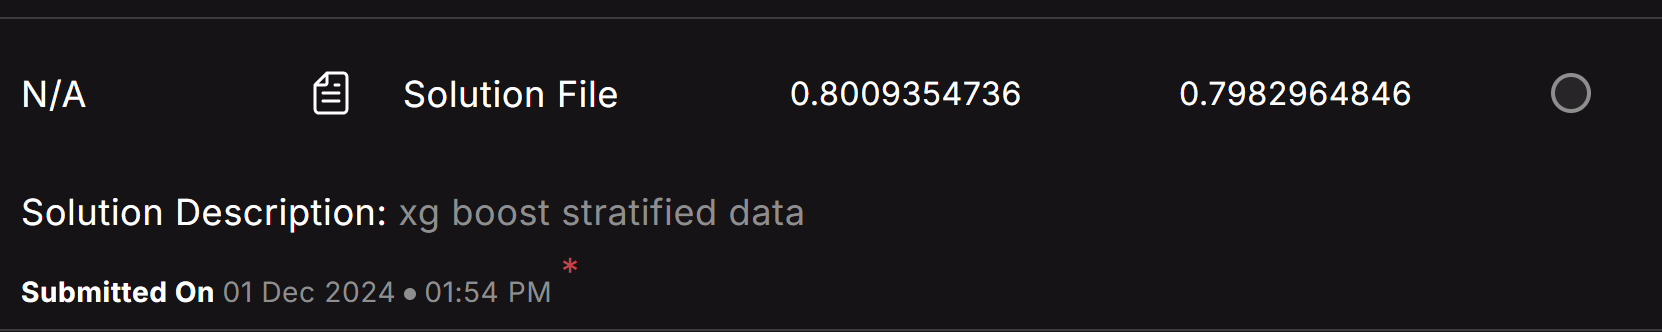

train auc
0.856503701075063
test auc
0.8447930703316502
train confusion matrix
[[227575  39944]
 [ 15777  21591]]
test confustion matrix
[[56622 10258]
 [ 4236  5106]]
train class matrix
              precision    recall  f1-score   support

           0       0.94      0.85      0.89    267519
           1       0.35      0.58      0.44     37368

    accuracy                           0.82    304887
   macro avg       0.64      0.71      0.66    304887
weighted avg       0.86      0.82      0.84    304887

test class matrix
              precision    recall  f1-score   support

           0       0.93      0.85      0.89     66880
           1       0.33      0.55      0.41      9342

    accuracy                           0.81     76222
   macro avg       0.63      0.70      0.65     76222
weighted avg       0.86      0.81      0.83     76222



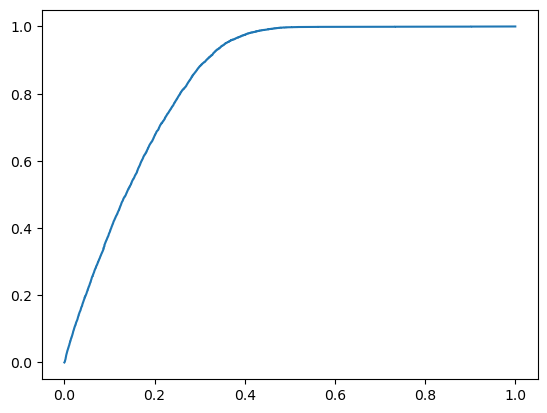

In [322]:
smote = SMOTE(random_state=2)
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

model_pipeline12 = Pipeline(
    steps=[
        ('preprocess', preprocess),
        ('smote', smote),
        ('model', XGBClassifier(
            n_estimators=1000,  
            learning_rate=0.07,  
            max_depth=6,  
            subsample=0.9,  
            colsample_bytree=0.35, 
            scale_pos_weight=1,  
            random_state=1,
            gamma  = 0.4,
            reg_alpha=0.05,   
            reg_lambda=1.0   
        ))
    ]
)
model_pipeline12.fit(train_X,train_y)
model_train_val_eval(train_X, val_X, train_y, val_y,model_pipeline12)

In [324]:
submission['Response']=model_pipeline12.predict(test)
submission.to_csv(r'C:\Users\infan\Documents\gayathri\cross_sell_prediction\csv files\XGboost_stratified_data.csv',index=False)

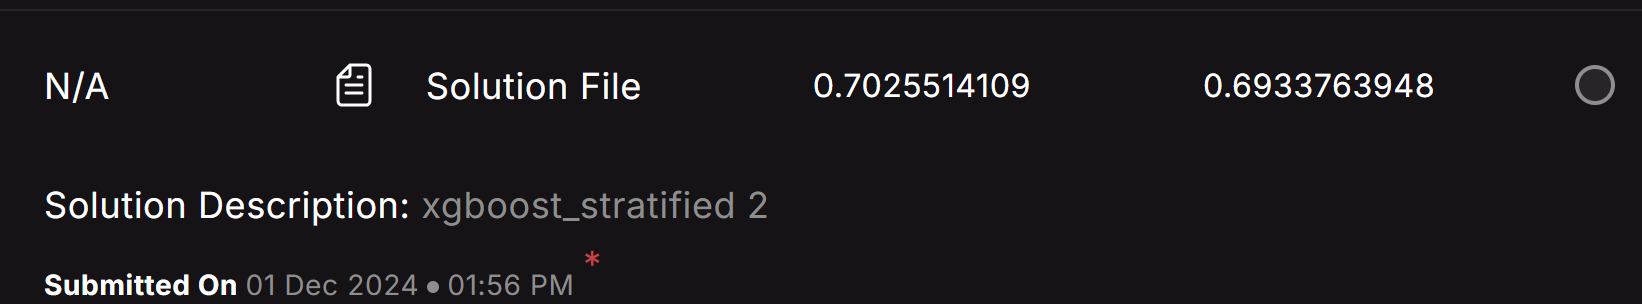

train auc
0.859802598558359
test auc
0.8597206641060745
train confusion matrix
[[179437  88082]
 [  2406  34962]]
test confustion matrix
[[44898 21982]
 [  605  8737]]
train class matrix
              precision    recall  f1-score   support

           0       0.99      0.67      0.80    267519
           1       0.28      0.94      0.44     37368

    accuracy                           0.70    304887
   macro avg       0.64      0.80      0.62    304887
weighted avg       0.90      0.70      0.75    304887

test class matrix
              precision    recall  f1-score   support

           0       0.99      0.67      0.80     66880
           1       0.28      0.94      0.44      9342

    accuracy                           0.70     76222
   macro avg       0.64      0.80      0.62     76222
weighted avg       0.90      0.70      0.75     76222



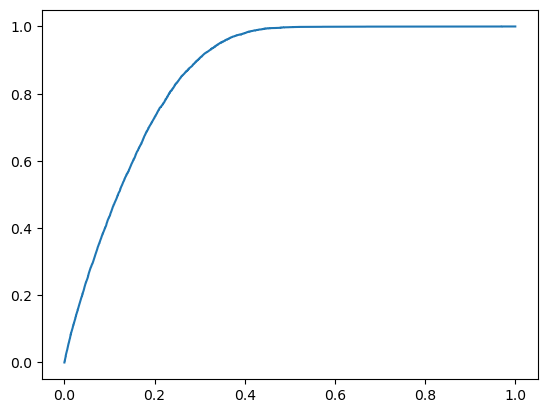

In [357]:
model_pipeline13=Pipeline(
    steps=[
        ('preprocess',preprocess),
        ('model',GradientBoostingClassifier(
            criterion='friedman_mse',
            max_depth=None,
            max_leaf_nodes= 20,
            min_samples_leaf=2,
            min_samples_split=5
        ))
    ]
)

model_pipeline13.fit(train_X_under_sampled,train_y_under_sampled)
model_train_val_eval(train_X, val_X, train_y, val_y,model_pipeline13)

submission['Response']=model_pipeline13.predict(test)
submission.to_csv(r'C:\Users\infan\Documents\gayathri\cross_sell_prediction\csv files\gradientboosting_tuning4.csv',index=False)

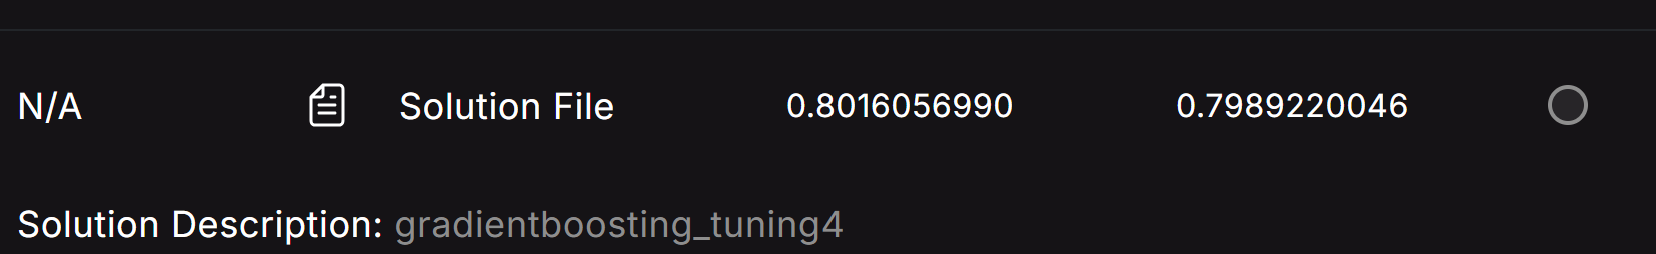

train auc
0.8616468227249303
test auc
0.861842857512351
train confusion matrix
[[179756  87763]
 [  2430  34938]]
test confustion matrix
[[45003 21877]
 [  615  8727]]
train class matrix
              precision    recall  f1-score   support

           0       0.99      0.67      0.80    267519
           1       0.28      0.93      0.44     37368

    accuracy                           0.70    304887
   macro avg       0.64      0.80      0.62    304887
weighted avg       0.90      0.70      0.75    304887

test class matrix
              precision    recall  f1-score   support

           0       0.99      0.67      0.80     66880
           1       0.29      0.93      0.44      9342

    accuracy                           0.70     76222
   macro avg       0.64      0.80      0.62     76222
weighted avg       0.90      0.70      0.76     76222



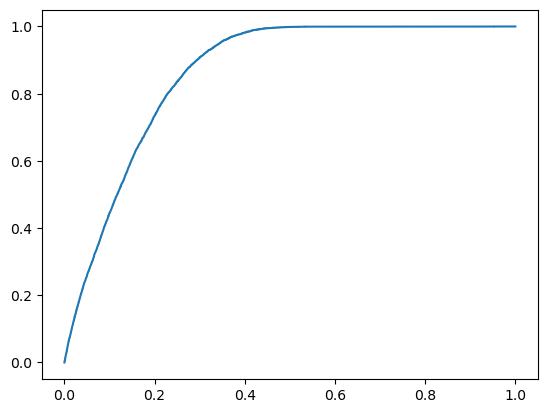

In [344]:
model_pipeline14 = Pipeline(
    steps=[
        ('preprocess', preprocess),
        ('model', GradientBoostingClassifier(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=5,
            max_leaf_nodes=25,
            min_samples_split=3,
            min_samples_leaf=2,
            subsample=0.8,
            random_state=42
        ))
    ]
)

model_pipeline14.fit(train_X_under_sampled, train_y_under_sampled)
model_train_val_eval(train_X, val_X, train_y, val_y, model_pipeline14)

submission['Response']=model_pipeline14.predict(test)
submission.to_csv(r'C:\Users\infan\Documents\gayathri\cross_sell_prediction\csv files\gradientboosting_tuning5.csv',index=False)


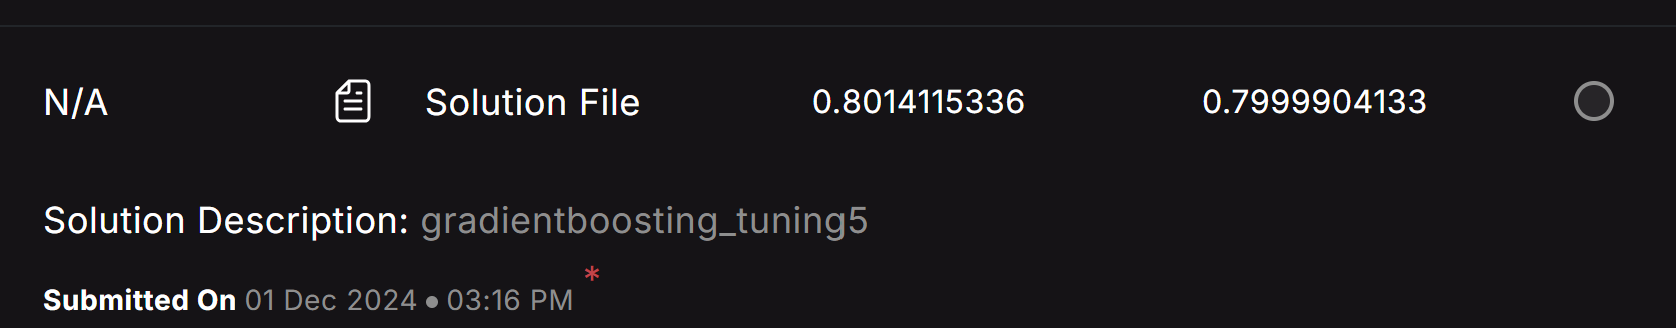

train auc
0.8640901140794888
test auc
0.8636946965599611
train confusion matrix
[[180283  87236]
 [  2387  34981]]
test confustion matrix
[[45155 21725]
 [  601  8741]]
train class matrix
              precision    recall  f1-score   support

           0       0.99      0.67      0.80    267519
           1       0.29      0.94      0.44     37368

    accuracy                           0.71    304887
   macro avg       0.64      0.81      0.62    304887
weighted avg       0.90      0.71      0.76    304887

test class matrix
              precision    recall  f1-score   support

           0       0.99      0.68      0.80     66880
           1       0.29      0.94      0.44      9342

    accuracy                           0.71     76222
   macro avg       0.64      0.81      0.62     76222
weighted avg       0.90      0.71      0.76     76222



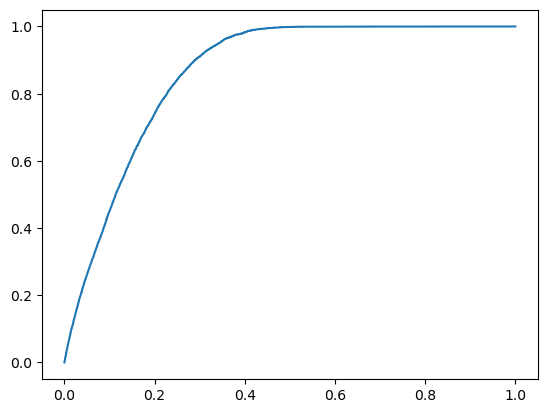

In [353]:
model_pipeline15 = Pipeline(
    steps=[
        ('preprocess', preprocess),
        ('model', GradientBoostingClassifier(
            n_estimators=500,
            learning_rate=0.045,
            max_depth=5,
            max_leaf_nodes=25,
            min_samples_split=3,
            min_samples_leaf=2,
            subsample=0.8,
            random_state=42
        ))
    ]
)

model_pipeline15.fit(train_X_under_sampled, train_y_under_sampled)
model_train_val_eval(train_X, val_X, train_y, val_y, model_pipeline15)

submission['Response']=model_pipeline15.predict(test)
submission.to_csv(r'C:\Users\infan\Documents\gayathri\cross_sell_prediction\csv files\gradientboosting_tuning6.csv',index=False)


In [355]:
model_pipeline16 = Pipeline(
    steps=[
        ('preprocess', preprocess),
        ('model', GradientBoostingClassifier(
            n_estimators=1000,
            learning_rate=0.035,
            max_depth=5,
            max_leaf_nodes=25,
            min_samples_split=3,
            min_samples_leaf=2,
            subsample=0.8,
            random_state=42
        ))
    ]
)

model_pipeline16.fit(train_X_under_sampled, train_y_under_sampled)
model_train_val_eval(train_X, val_X, train_y, val_y, model_pipeline16)


KeyboardInterrupt: 

In [351]:
submission['Response']=model_pipeline16.predict(test)
submission.to_csv(r'C:\Users\infan\Documents\gayathri\cross_sell_prediction\csv files\gradientboosting_tuning8.csv',index=False)

In [359]:
#joblib
import joblib
joblib.dump(model_pipeline13,'cross-sell-prediction.pkl')

['cross-sell-prediction.pkl']

In [361]:
train.iloc[0]

id                              1
Gender                       Male
Age                            44
Driving_License                 1
Region_Code                  28.0
Previously_Insured              0
Vehicle_Age             > 2 Years
Vehicle_Damage                Yes
Annual_Premium            40454.0
Policy_Sales_Channel         26.0
Vintage                       217
Response                        1
Name: 0, dtype: object

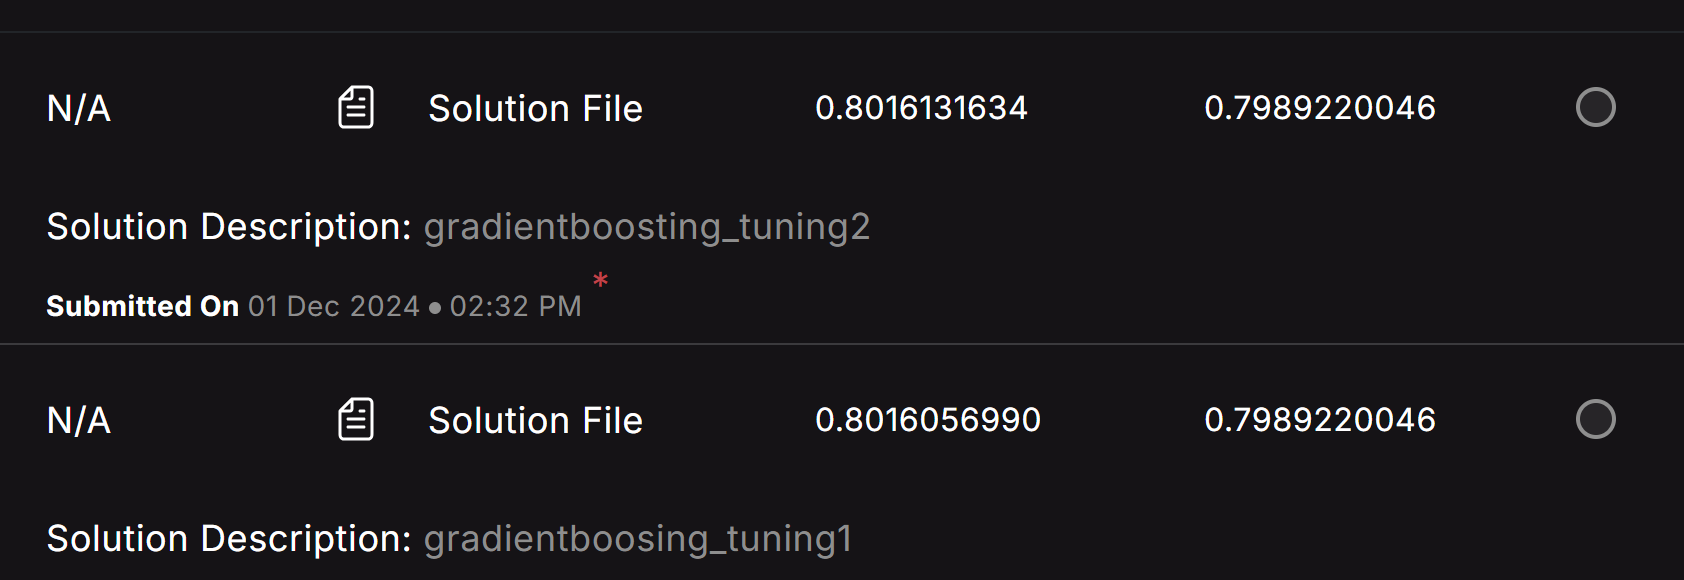